## Лабораторная работа №2

**Тема:** MNIST и MLP

**Выполнил:** Студент группы БВТ2201 Шамсутдинов Рустам Фаргатевич

**Цель лабораторной работы:** Создать модель с архитектурой MLP для распознования ручных цифр (MNIST)

In [1]:
# Импорт необходимых библиотек
import math

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms


In [2]:
# Проверка доступности CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

Используется устройство: cpu


In [3]:
# Создание пользовательского датасета
class MNISTDataset(Dataset):
    """Пользовательский класс датасета для MNIST"""

    def __init__(self, root, train=True, transform=None, download=True):
        self.mnist_dataset = datasets.MNIST(
            root=root,
            train=train,
            transform=transform,
            download=download
        )
        self.classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        one_hot = torch.zeros(10)
        one_hot[label] = 1
        return image, label, one_hot

    def get_class_names(self):
        return self.classes

In [4]:
# Настройка трансформации данных
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
# Создание экземпляров пользовательских датасетов
train_dataset = MNISTDataset(root='./data', train=True, transform=transform, download=True)
test_dataset = MNISTDataset(root='./data', train=False, transform=transform, download=True)


In [6]:
# Параметры для даталоадеров
batch_size = 64
num_workers = 2

In [7]:
# Создание даталоадеров
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [8]:
# Проверка данных
images, labels, one_hot = next(iter(train_loader))
print(f"Форма батча изображений: {images.shape}")
print(f"Форма батча меток: {labels.shape}")
print(f"Форма батча one-hot векторов: {one_hot.shape}")
print(f"Тип данных изображений: {images.dtype}")


Форма батча изображений: torch.Size([64, 1, 28, 28])
Форма батча меток: torch.Size([64])
Форма батча one-hot векторов: torch.Size([64, 10])
Тип данных изображений: torch.float32


In [9]:
# Проверка диапазона значений пикселей
print(f"Минимальное значение пикселя: {images.min()}")
print(f"Максимальное значение пикселя: {images.max()}")


Минимальное значение пикселя: 0.0
Максимальное значение пикселя: 1.0


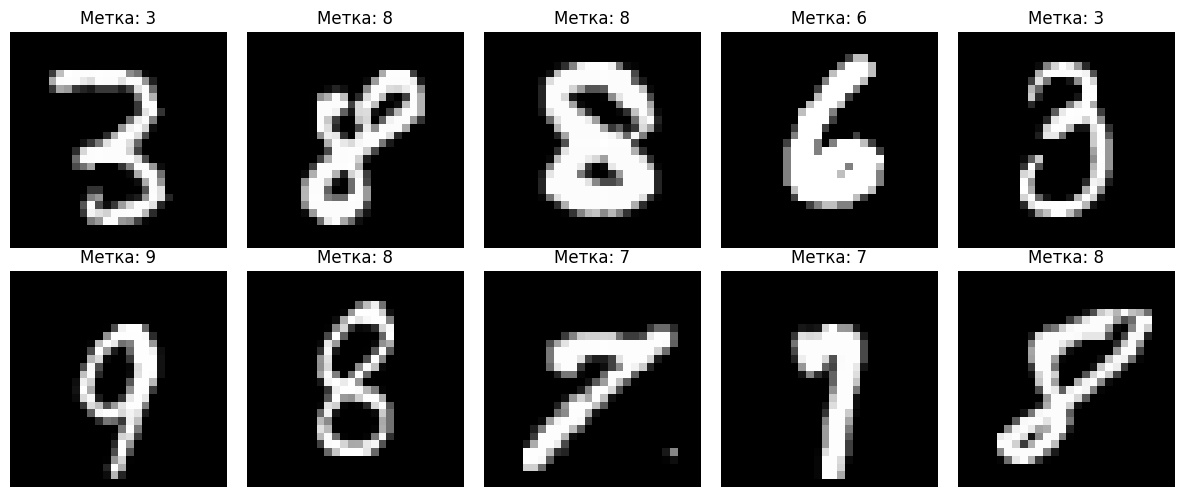

In [10]:
# Вывод нескольких примеров
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    img = images[i][0].numpy()
    label = labels[i].item()

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Метка: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [11]:
# Архитектура MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.classifier = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        logits = self.classifier(x)
        return logits

    def predict_proba(self, x):
        logits = self.forward(x)
        return self.softmax(logits)

In [12]:
# Инициализация модели
model = MLP().to(device)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [13]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Функции обучения и тестирования
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets, _) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(dataloader):
            print(f'Батч: {batch_idx + 1}/{len(dataloader)} | Потери: {running_loss / (batch_idx + 1):.4f} | Точность: {100. * correct / total:.2f}%')

    return running_loss / len(dataloader), 100. * correct / total

In [15]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets, _ in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(dataloader)

    print(f'Тестирование - Потери: {avg_loss:.4f} | Точность: {accuracy:.2f}%')

    return avg_loss, accuracy, all_targets, all_predictions

In [16]:
# Обучение модели
num_epochs = 5
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print(f"Начало обучения модели на {device}")

for epoch in range(num_epochs):
    print(f"\nЭпоха {epoch + 1}/{num_epochs}")
    print('-' * 60)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

print("Обучение завершено!")

Начало обучения модели на cpu

Эпоха 1/5
------------------------------------------------------------
Батч: 100/938 | Потери: 0.8340 | Точность: 74.66%
Батч: 200/938 | Потери: 0.5967 | Точность: 82.01%
Батч: 300/938 | Потери: 0.4778 | Точность: 85.59%
Батч: 400/938 | Потери: 0.4119 | Точность: 87.60%
Батч: 500/938 | Потери: 0.3685 | Точность: 88.92%
Батч: 600/938 | Потери: 0.3356 | Точность: 89.91%
Батч: 700/938 | Потери: 0.3092 | Точность: 90.75%
Батч: 800/938 | Потери: 0.2888 | Точность: 91.35%
Батч: 900/938 | Потери: 0.2731 | Точность: 91.85%
Батч: 938/938 | Потери: 0.2664 | Точность: 92.03%
Тестирование - Потери: 0.1060 | Точность: 96.85%

Эпоха 2/5
------------------------------------------------------------
Батч: 100/938 | Потери: 0.1027 | Точность: 97.14%
Батч: 200/938 | Потери: 0.1034 | Точность: 96.95%
Батч: 300/938 | Потери: 0.1048 | Точность: 96.90%
Батч: 400/938 | Потери: 0.1042 | Точность: 96.89%
Батч: 500/938 | Потери: 0.1032 | Точность: 96.89%
Батч: 600/938 | Потери: 0.1

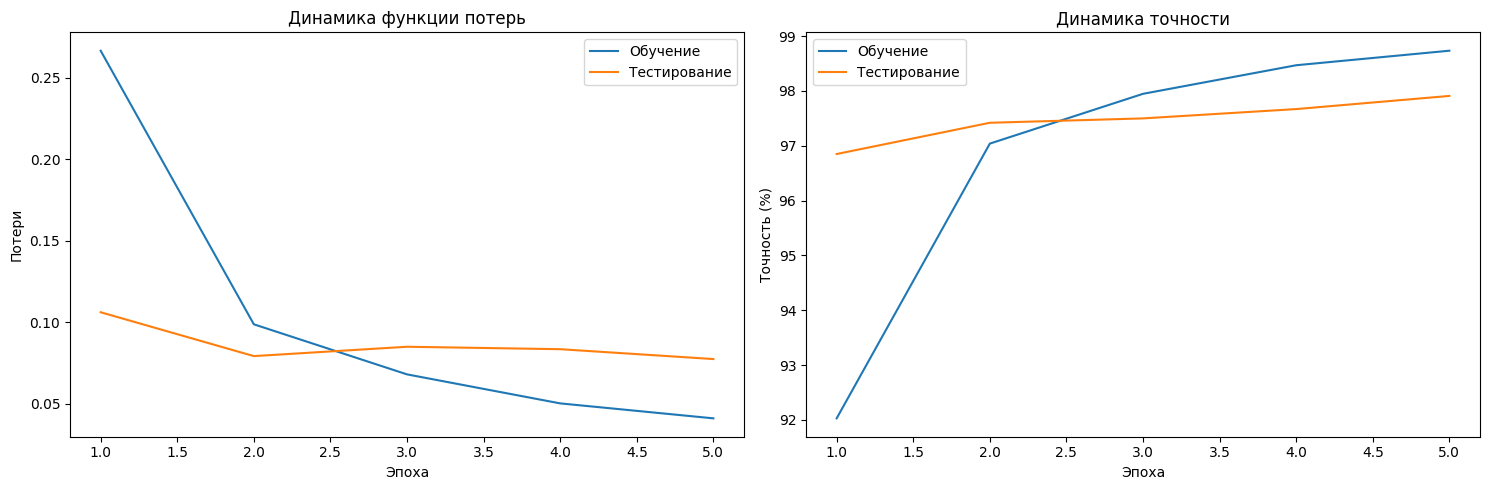

In [17]:
# Построение графиков обучения
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Обучение')
plt.plot(range(1, num_epochs + 1), test_losses, label='Тестирование')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.title('Динамика функции потерь')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Обучение')
plt.plot(range(1, num_epochs + 1), test_accs, label='Тестирование')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.legend()
plt.title('Динамика точности')

plt.tight_layout()
plt.show()

In [18]:
# Сохранение обученной модели
torch.save(model.state_dict(), 'mnist_mlp_model.pth')
print("Модель сохранена в 'mnist_mlp_model.pth'")

Модель сохранена в 'mnist_mlp_model.pth'


In [19]:
# Оценка модели на тестовом наборе данных
_, _, y_true, y_pred = evaluate(model, test_loader, criterion, device)

Тестирование - Потери: 0.0773 | Точность: 97.91%


In [20]:
# Расчет и вывод метрик
print("\nОтчет по классификации:")
class_names = train_dataset.get_class_names()
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)


Отчет по классификации:
              precision    recall  f1-score   support

           0     0.9663    0.9959    0.9809       980
           1     0.9894    0.9894    0.9894      1135
           2     0.9844    0.9787    0.9815      1032
           3     0.9840    0.9762    0.9801      1010
           4     0.9807    0.9817    0.9812       982
           5     0.9777    0.9809    0.9793       892
           6     0.9893    0.9656    0.9773       958
           7     0.9767    0.9796    0.9781      1028
           8     0.9692    0.9702    0.9697       974
           9     0.9722    0.9713    0.9717      1009

    accuracy                         0.9791     10000
   macro avg     0.9790    0.9789    0.9789     10000
weighted avg     0.9792    0.9791    0.9791     10000



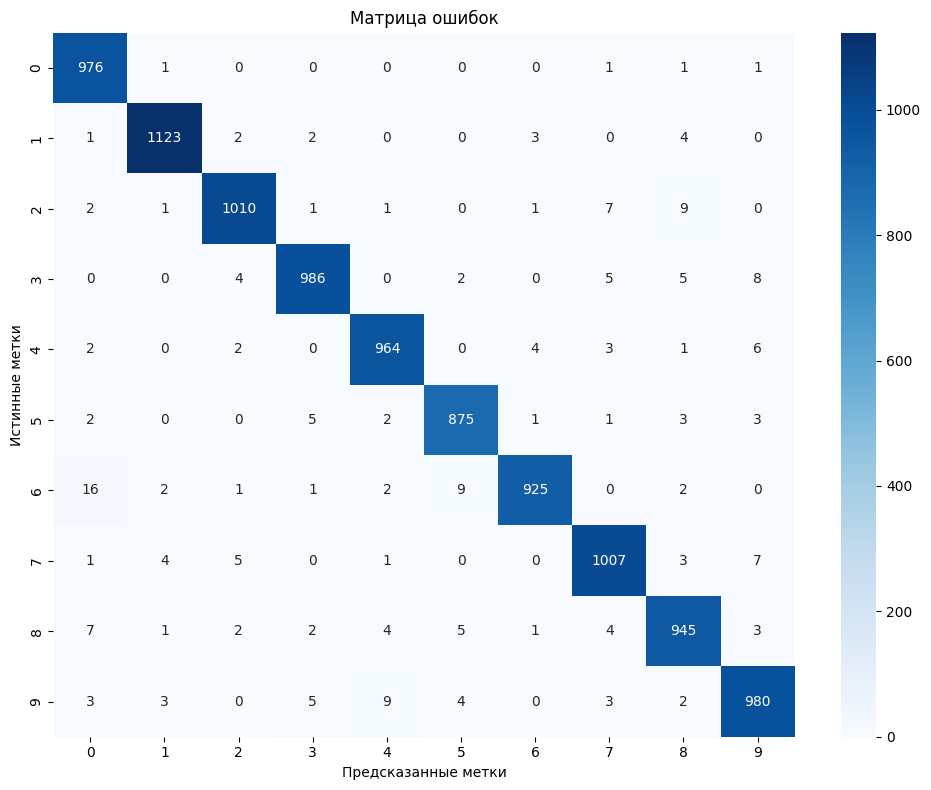

In [21]:
# Построение матрицы ошибок
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

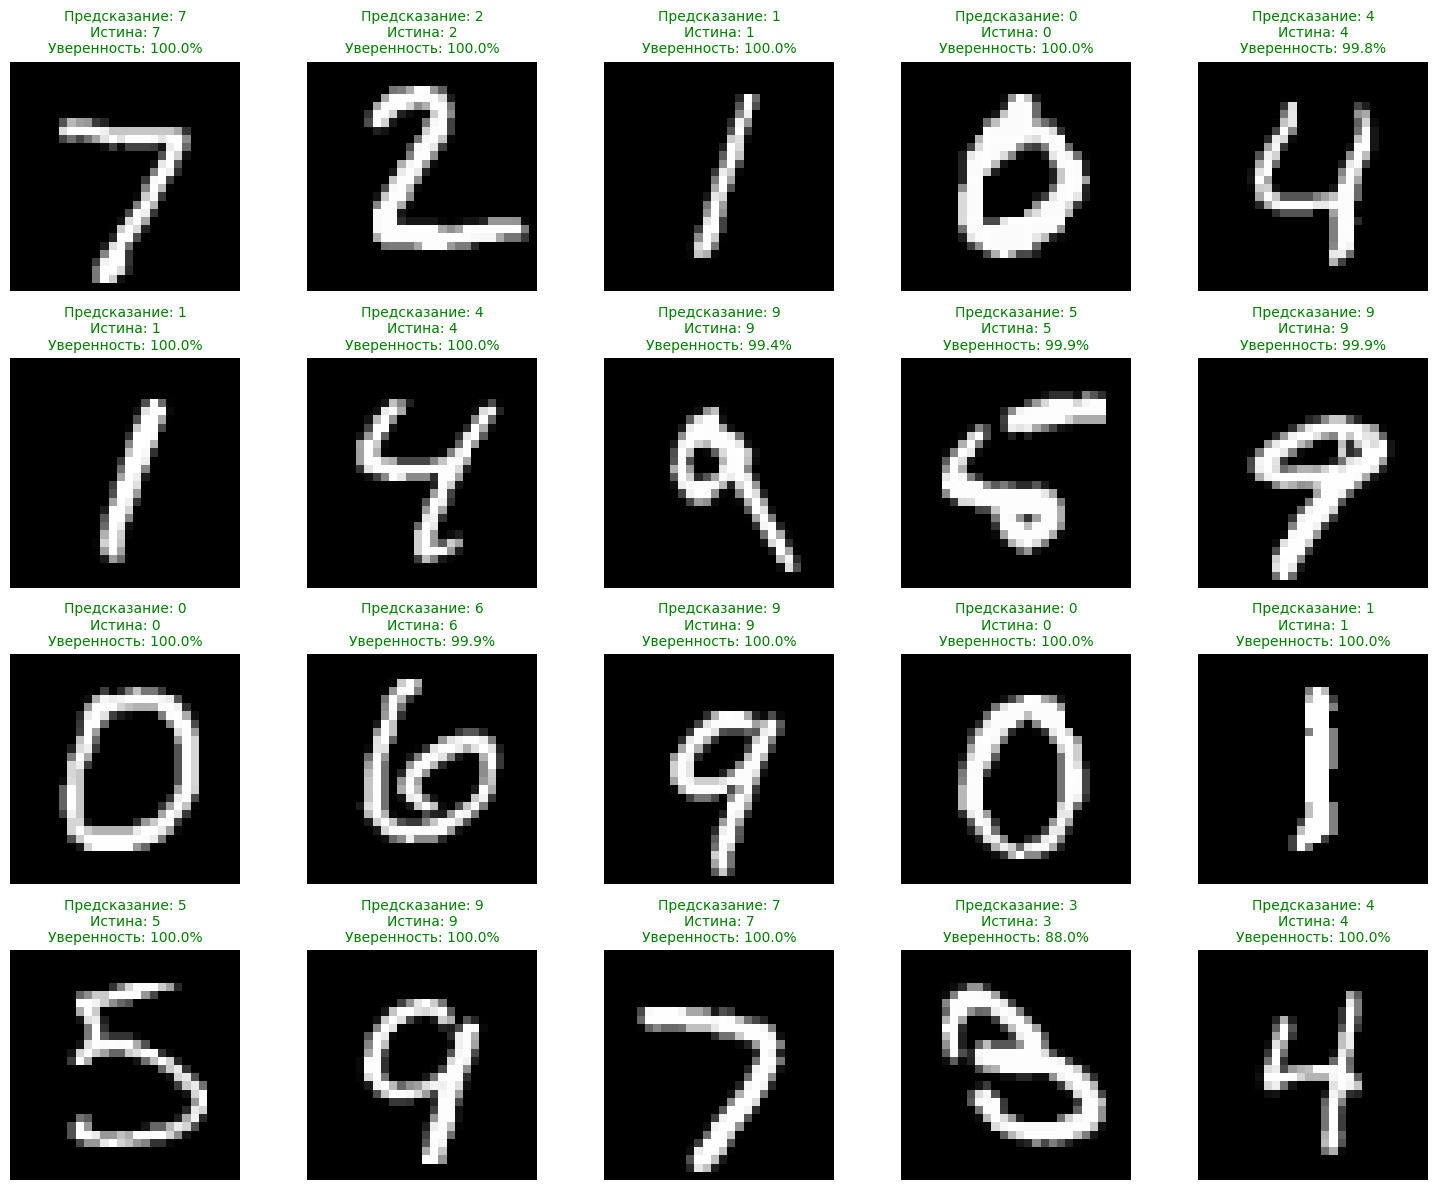

In [29]:
# Визуализация примеров с предсказаниями
def visualize_examples(model, dataloader, device, num_examples=20):
    model.eval()

    dataiter = iter(dataloader)
    images, labels, _ = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        # probs = F.softmax(outputs, dim=1)
        probs = model.predict_proba(images)
        _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(15, math.ceil(num_examples/5) * 3))
    for i in range(num_examples):
        ax = fig.add_subplot(math.ceil(num_examples/5), 5, i + 1)

        img = images[i].cpu().squeeze().numpy()
        true_label = labels[i].item()
        pred_label = predicted[i].item()
        prob = probs[i][pred_label].item() * 100

        ax.imshow(img, cmap='gray')

        title_color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f'Предсказание: {pred_label}\nИстина: {true_label}\nУверенность: {prob:.1f}%',
                     color=title_color, fontsize=10)

        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_examples(model, test_loader, device, num_examples=20)